In [227]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

In [228]:
def load_images():
    image_names = os.listdir("test_images")
    images_arr = []
    np.random.seed(0)
    for image_name in image_names:
        julian_date = float(".".join(image_name.split(".")[0:2]))
        image = np.array(Image.open(f"test_images/{image_name}")).astype(np.float32)
        # image = np.array(Image.open(f"test_images/{image_names[0]}")).astype(np.float32)
        # # Create output image
        images_arr.append((julian_date, image))

    for i in range(2):
        images_arr = images_arr + images_arr
    return images_arr

def get_timesteps(images_arr):
    timesteps = [image[0] for image in images_arr]
    timesteps.sort()
    # normalize
    # timesteps = [(timestep - timesteps[0]) for timestep in timesteps]
    timesteps = list(range(len(timesteps)))#[0, 1, 2, 3]
    return timesteps


In [229]:
def simulate_point_linear_source(image, position, velocity, time, fill=65):
    image_copy = image.copy()
    new_position = position + velocity * time
    new_position = new_position.astype(int)
    image_copy[new_position[0], new_position[1]] = fill
    # noise = np.random.normal(0, 15.8, image_copy.shape)
    # image_copy = image_copy + noise
    # image_copy = np.clip(image_copy, 0, 130)
    image_copy = image_copy.astype(np.uint8)
    return image_copy, new_position

trajectory = []

def moving_source_gif(images, position, velocity, timesteps):
    timeseries = []
    for i in range(len(timesteps)):
        simulated_image, new_position = simulate_point_linear_source(images[i], position, velocity, timesteps[i])
        trajectory.append(new_position)
        timeseries.append(simulated_image)
    timeseries_gif = [Image.fromarray(image.astype(np.uint8), mode='L').convert('RGB') for image in timeseries]
    timeseries_gif[0].save(
        'animated_moving_source.gif',
        save_all=True,
        append_images=timeseries_gif[1:],
        optimize=False,
        duration=100,
        loop=0
    )

    return np.array(timeseries)


In [230]:
image_time_pairs = load_images()
timesteps = get_timesteps(image_time_pairs)
images = [image[1] for image in image_time_pairs]

data = moving_source_gif(images, np.array([100, 100]), np.array([1, 2]), timesteps)

In [231]:
def apply_wavelet_transform(data, wavelet):
    coeffs = pywt.dwtn(data, wavelet)
    return coeffs

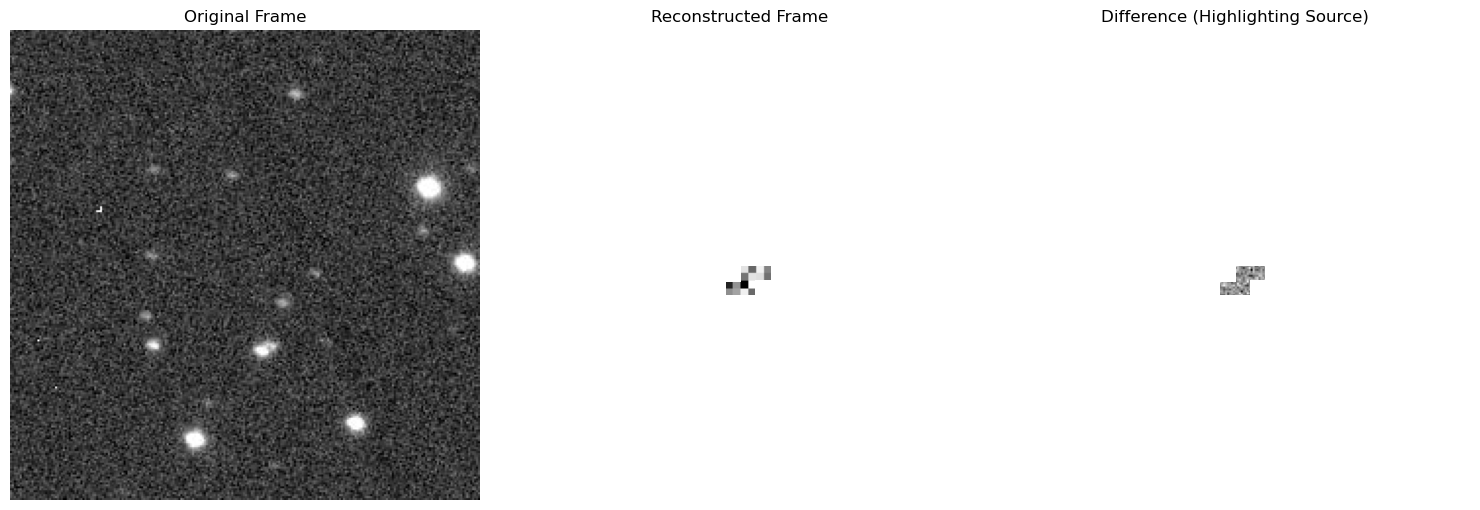

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


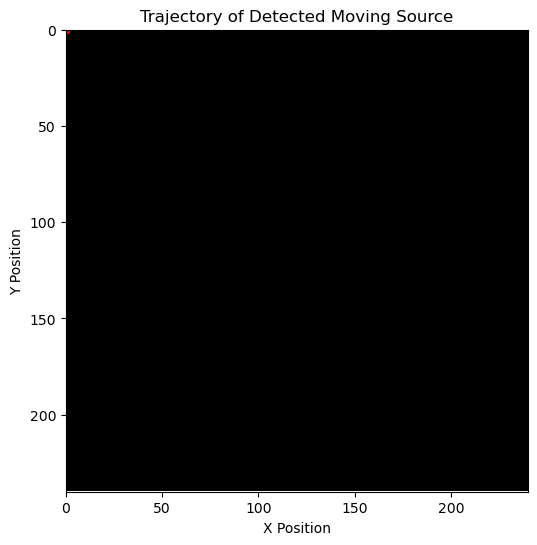

In [232]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Assuming 'data' is your 3D numpy array (time x height x width)
# data = ...

# Parameters
num_frames = data.shape[0]
height = data.shape[1]
width = data.shape[2]

wavelet = 'db1'

# Perform n-dimensional wavelet decomposition using wavedecn
coeffs = pywt.wavedecn(data, wavelet=wavelet)

# Initialize a list to hold the thresholded coefficients
coeffs_thresholded = [coeffs[0]]  # Do not threshold the approximation coefficients

# Loop over each level starting from level 1
for i in range(1, len(coeffs)):
    # Get detail coefficients at this level
    detail_coeffs = coeffs[i]
    
    # Collect all coefficients at this level into a single array
    coeffs_arr = np.concatenate([v.ravel() for v in detail_coeffs.values()])
    
    # Estimate noise sigma at this level using Median Absolute Deviation
    sigma = np.median(np.abs(coeffs_arr)) / 0.6745  # As per Donoho and Johnstone
    
    # Compute threshold for this level
    threshold = sigma * np.sqrt(2 * np.log(coeffs_arr.size))
    
    # Alternatively, use a fixed threshold or a percentage of sigma
    # threshold = sigma * some_factor  # Adjust 'some_factor' as needed
    
    # Threshold the detail coefficients at this level
    detail_coeffs_thresholded = {}
    for key in detail_coeffs.keys():
        detail_coeffs_thresholded[key] = pywt.threshold(
            detail_coeffs[key], threshold, mode='soft'
        )
    
    # Append the thresholded coefficients to the list
    coeffs_thresholded.append(detail_coeffs_thresholded)

# Reconstruct the data from thresholded coefficients
data_reconstructed = pywt.waverecn(coeffs_thresholded, wavelet=wavelet)

# Ensure the reconstructed data has the same shape as the original data
data_reconstructed = data_reconstructed[:data.shape[0], :data.shape[1], :data.shape[2]]

# Find the moving source by calculating the difference
difference = data_reconstructed - data

# Visualize the original data and reconstructed data at a specific time frame
time_frame = num_frames // 2  # Middle frame for visualization

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(data[time_frame], cmap='gray', origin='lower')
plt.title('Original Frame')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(data_reconstructed[time_frame], cmap='gray', origin='lower')
plt.title('Reconstructed Frame')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(difference[time_frame], cmap='gray', origin='lower')
plt.title('Difference (Highlighting Source)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot the trajectory of the detected moving source
# Identify positions with significant intensity in the difference frames
source_positions = []
for t in range(num_frames):
    frame = difference[t]
    # Find the position of the maximum absolute intensity
    y, x = np.unravel_index(np.argmax(np.abs(frame)), frame.shape)
    source_positions.append((x, y))

# Extract x and y coordinates
x_vals, y_vals = zip(*source_positions)
print(x_vals, y_vals)

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.imshow(np.zeros((height, width)), cmap='gray', origin='lower')
plt.plot(x_vals, y_vals, '-o', color='red', markersize=4)
plt.title('Trajectory of Detected Moving Source')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.xlim(0, width)
plt.ylim(0, height)
plt.gca().invert_yaxis()
plt.show()


In [233]:
reconstructed, difference, trajectories = process_astrometric_data(
    data,
    wavelet='db4',
    base_threshold=3.0
)


TypeError: dwtn() got an unexpected keyword argument 'level'

[array([100, 100]),
 array([101, 102]),
 array([102, 104]),
 array([103, 106]),
 array([104, 108]),
 array([105, 110]),
 array([106, 112]),
 array([107, 114]),
 array([108, 116]),
 array([109, 118]),
 array([110, 120]),
 array([111, 122]),
 array([112, 124]),
 array([113, 126]),
 array([114, 128]),
 array([115, 130])]